## Data acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel
from scipy.signal import find_peaks
from scipy import optimize as optim

import sys
sys.path.append('Library')

import drop_detection_tools as ddt


from importlib import reload


from tqdm import tqdm
%matplotlib inline

<Figure size 432x288 with 0 Axes>

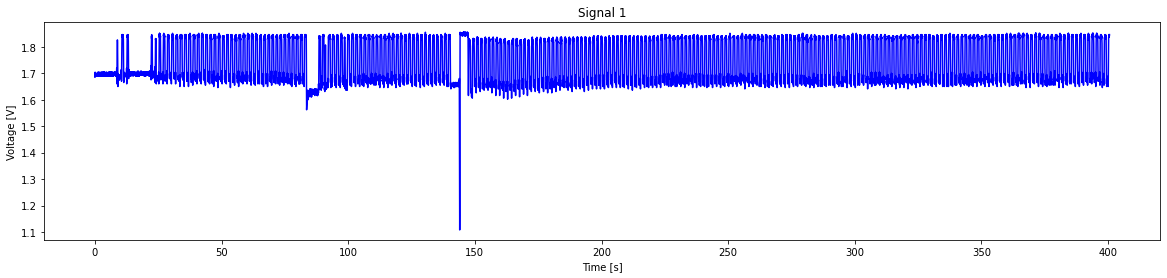

<Figure size 432x288 with 0 Axes>

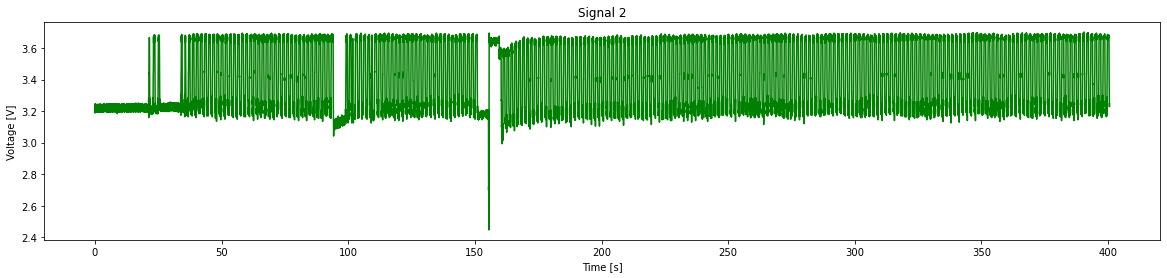

In [2]:
#************************************
folder   = '../../T-data/2-12/'
filename = 'B-ol10-aq10-pause10.csv'
name     = '2-12_B-ol5-aq5'
#************************************

raw = True 
sig1, sig2, t = ddt.read_LV(folder, filename)

### Resample data

(170.0, 200.0)

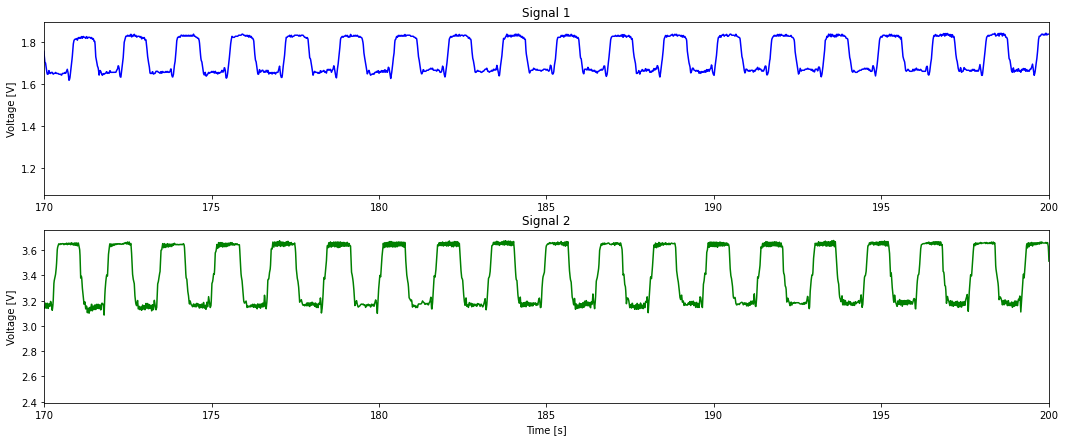

In [3]:
#******************************
dt = 0.01  # sampling time [s]
#******************************

# Resampling of the two signals
if raw:
    sig1, new_t = ddt.resample(sig1, t, dt=dt)
    sig2, _     = ddt.resample(sig2, t, dt=dt)
    t           = new_t
    raw         = False 
else:
    print('data already resampled')

    
# Signals plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,7))

# Signal 1
axs[0].plot(t, sig1, color='blue')
axs[0].set_title('Signal 1')
axs[0].set_ylabel('Voltage [V]')
#axs[0].set_xlabel('Time [s]')
axs[0].set_xlim(170,200)

# Signal 2
axs[1].plot(t, sig2, color='green')
axs[1].set_title('Signal 2')
axs[1].set_ylabel('Voltage [V]')
axs[1].set_xlabel('Time [s]')
axs[1].set_xlim(170,200)


In [4]:
def lin_func(x,a,b):
    return a*x + b

In [5]:
def normalize(signal, fit_func, xdata=None, plot_switch=False):
    signal = np.array(signal)
    if xdata is None:
        xdata = np.arange(len(signal))
    else:
        xdata = np.array(xdata)
    
    # make the signal with zero mean
    z_sig = signal - np.mean(signal)
    
    # fit the decay
    popt, pcov = optim.curve_fit(fit_func, xdata, np.abs(z_sig))
    fit_curve = fit_func(xdata,*popt)
    
    n_sig = z_sig/fit_curve
    
    fig = None
    if plot_switch:
        fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
        axs[0].plot(xdata, z_sig, alpha=0.2, color='blue')
        axs[0].plot(xdata, np.abs(z_sig), color='blue')
        axs[0].plot(xdata, fit_curve, color='orange')
        axs[1].plot(xdata, signal, color='green', label='original signal')
        axs[0].set_xlabel('Time [s]')
        axs[0].set_ylabel('Voltage [V]') 
        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('Voltage [V]')
        #axs[1].set_ylim(-2,2)
        ax2 = axs[1].twinx()
        ax2.plot(xdata, n_sig, color='red', label='normalized signal')
        ax2.tick_params(axis = 'y', labelcolor = 'red')
        ax2.set_ylabel('Voltage [V]') 
        #ax2.set_xlim(100,160)
        #ax2.set_ylim(-2,2)
        fig.legend()
    
    return fig, n_sig

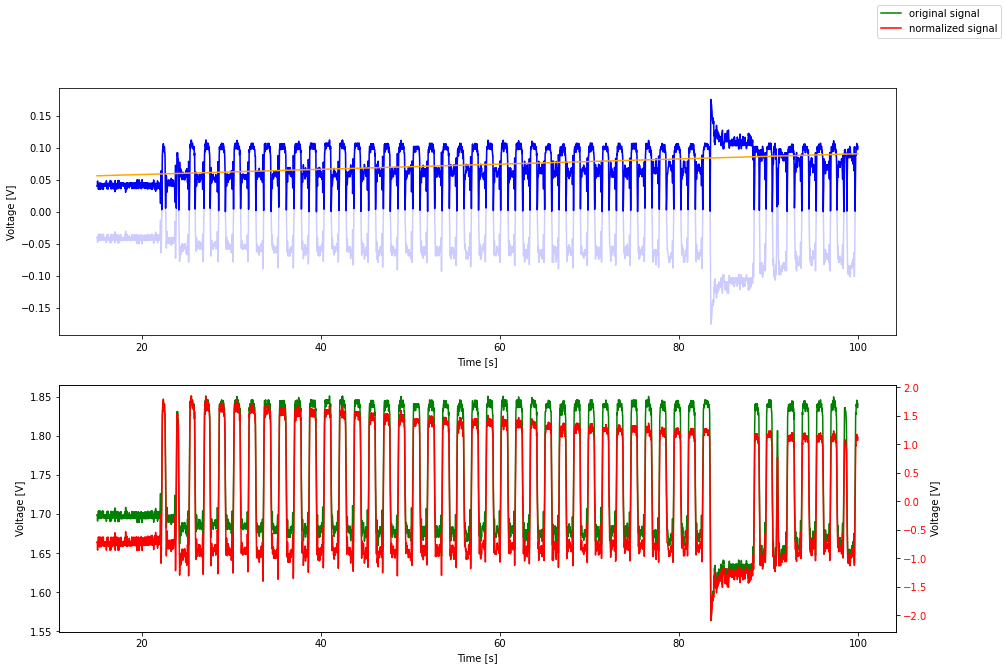

In [6]:
xmin = 1500
xmax = 10000

%matplotlib inline

time = t[xmin:xmax]
sig = sig1[xmin:xmax]

fig, n_sig = normalize(sig, lin_func, time, plot_switch=True)

# sig1 = n_sig

In [7]:
# rectification

def rectify(signal, fit_func, xdata=None, plot_switch=False, ignore_bias=-1, **kwargs):
    p0 = kwargs.pop('p0', None)
    bounds = kwargs.pop('bounds', None)
    if bounds is None:
        bounds = (-np.inf, np.inf)
    
    signal = np.array(signal)
    if xdata is None:
        xdata = np.arange(len(signal))
    else:
        xdata = np.array(xdata)
        
    main_mean = np.mean(signal)
    
    lower_mean = np.mean([s for s in signal if s < main_mean])
    upper_mean = np.mean([s for s in signal if s >= main_mean])
    
    pivot = 0.5*(lower_mean + upper_mean)
    
    z_sig = signal - pivot
    
    fit_mask = [(s > ignore_bias) for s in np.abs(z_sig)]
    
    popt, pcov = optim.curve_fit(fit_func, xdata[fit_mask], np.abs(z_sig)[fit_mask],p0=p0, bounds=bounds)
    fit_curve = fit_func(xdata,*popt)
    
    n_sig = z_sig/fit_curve
    
    fig = None
    if plot_switch:
        fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
        axs[0].plot(xdata, z_sig, alpha=0.2, color='blue')
        axs[0].plot(xdata[fit_mask], np.abs(z_sig)[fit_mask], color='blue')
        axs[0].plot(xdata, fit_curve, color='orange')
        axs[1].plot(xdata, signal, color='green', label='original signal')
        axs[0].set_xlabel('Time [s]')
        axs[0].set_ylabel('Voltage [V]') 
        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('Voltage [V]')
        #axs[1].set_ylim(-2,2)
        ax2 = axs[1].twinx()
        ax2.plot(xdata, n_sig, color='red', label='normalized signal')
        ax2.tick_params(axis = 'y', labelcolor = 'red')
        ax2.set_ylabel('Voltage [V]') 
        #ax2.set_xlim(100,160)
        #ax2.set_ylim(-2,2)
        fig.legend()
    
    return fig, n_sig

In [8]:
reload(plt)

<module 'matplotlib.pyplot' from 'C:\\Users\\Utente\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
def bell_func(x, c, a, lam, b):
    return a*np.tanh((x-c)/lam) + b

In [10]:
def bump_func(x,c,a,lam,b):
    return b + a*np.exp(-((x-c)/lam)**2)

In [11]:
%matplotlib notebook
# %matplotlib notebook

xmin = 0
xmax = -1

# %matplotlib inline

# time = t[xmin:xmax]
# sig = sig1[xmin:xmax]

fig, r_sig = rectify(sig1_high[15000:], bump_func, plot_switch=True, ignore_bias=0.06)

# sig1 = n_sig

NameError: name 'sig1_high' is not defined

<IPython.core.display.Javascript object>


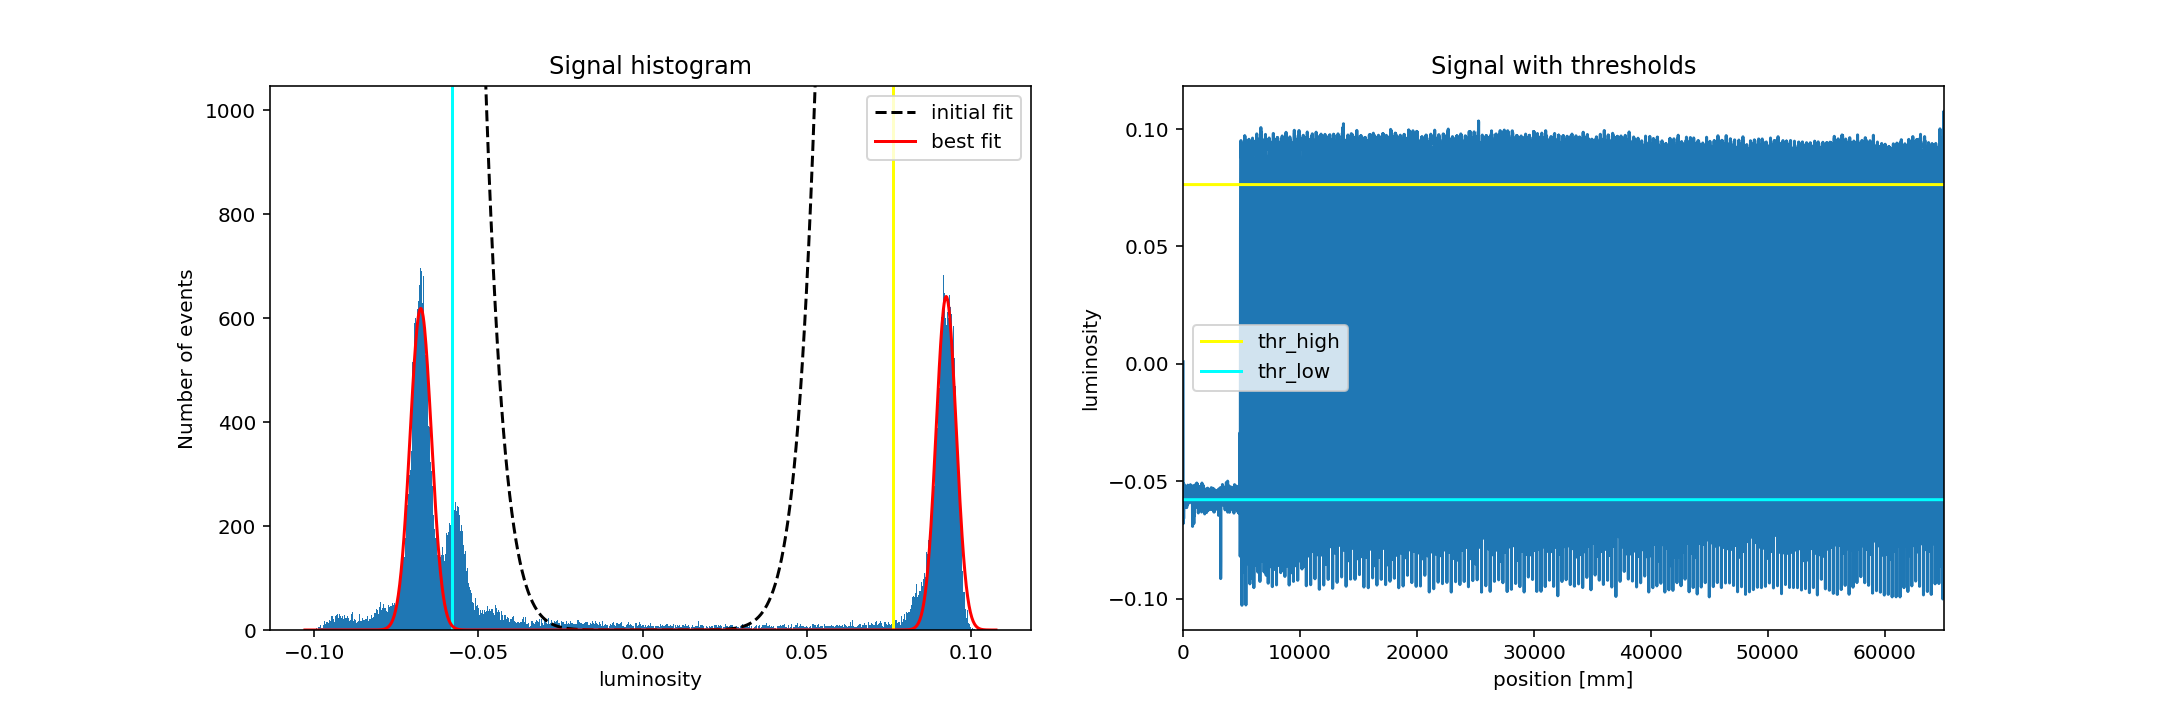

(-0.05789346004824046, 0.07636154879406029)

In [39]:
ddt.thr_searcher(sig1_high,nbins=1000)

<IPython.core.display.Javascript object>


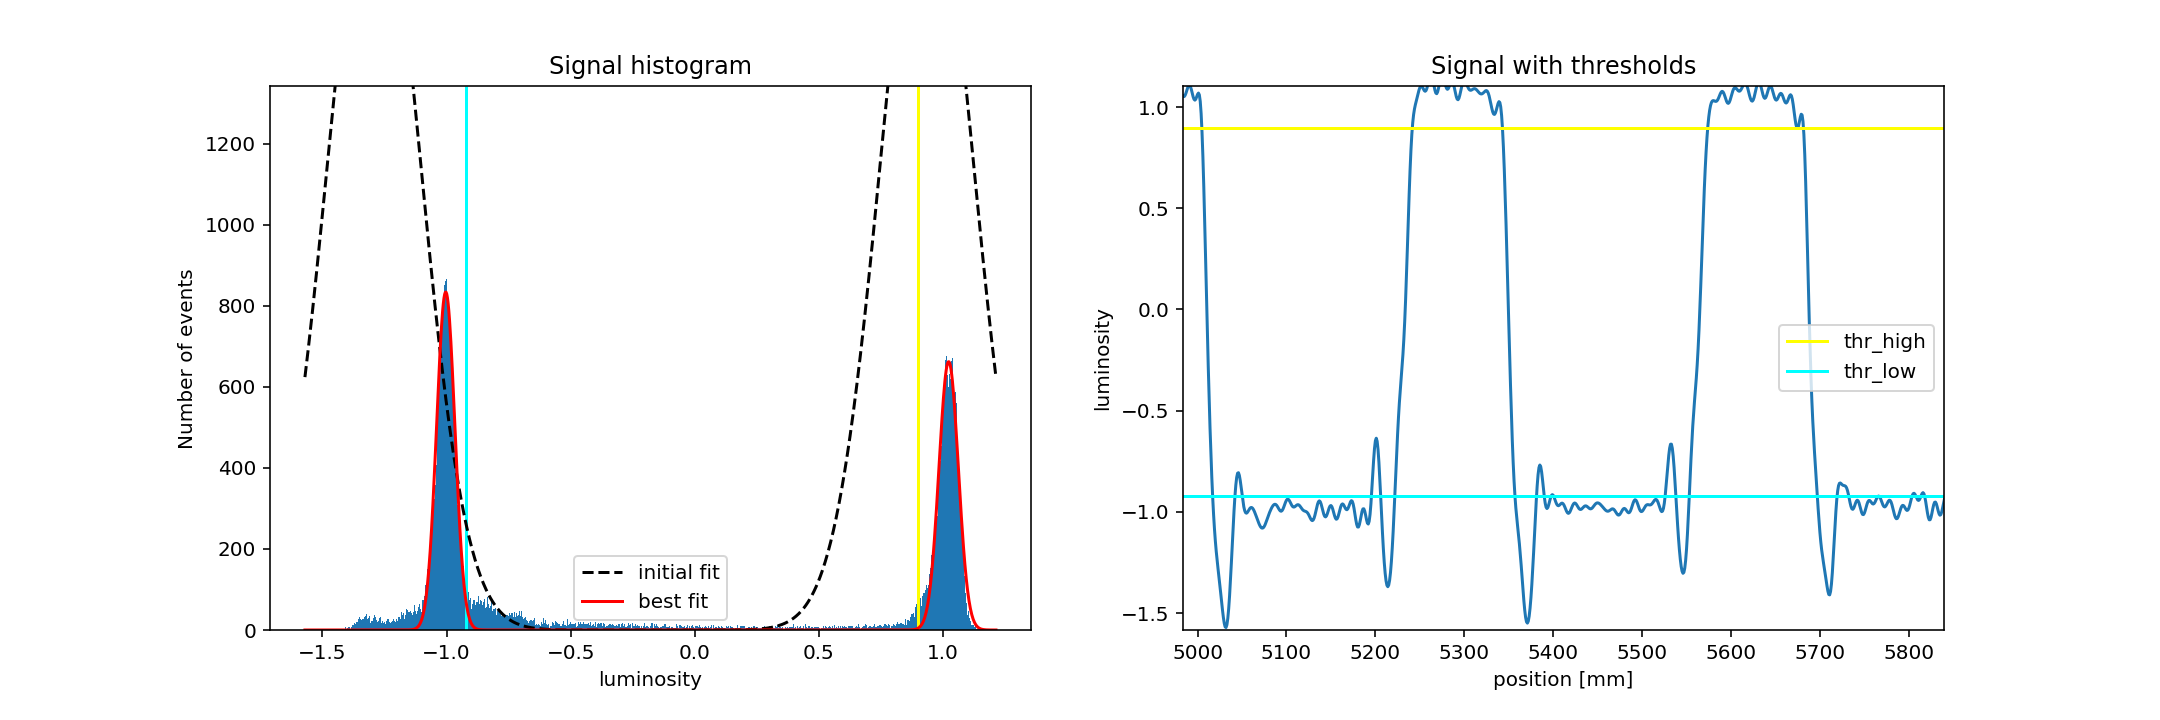

(-0.9201582159481906, 0.8989256772035561)

In [65]:
ddt.thr_searcher(r_sig,nbins=1000, high_sigmas=3, low_sigmas=2)

<IPython.core.display.Javascript object>


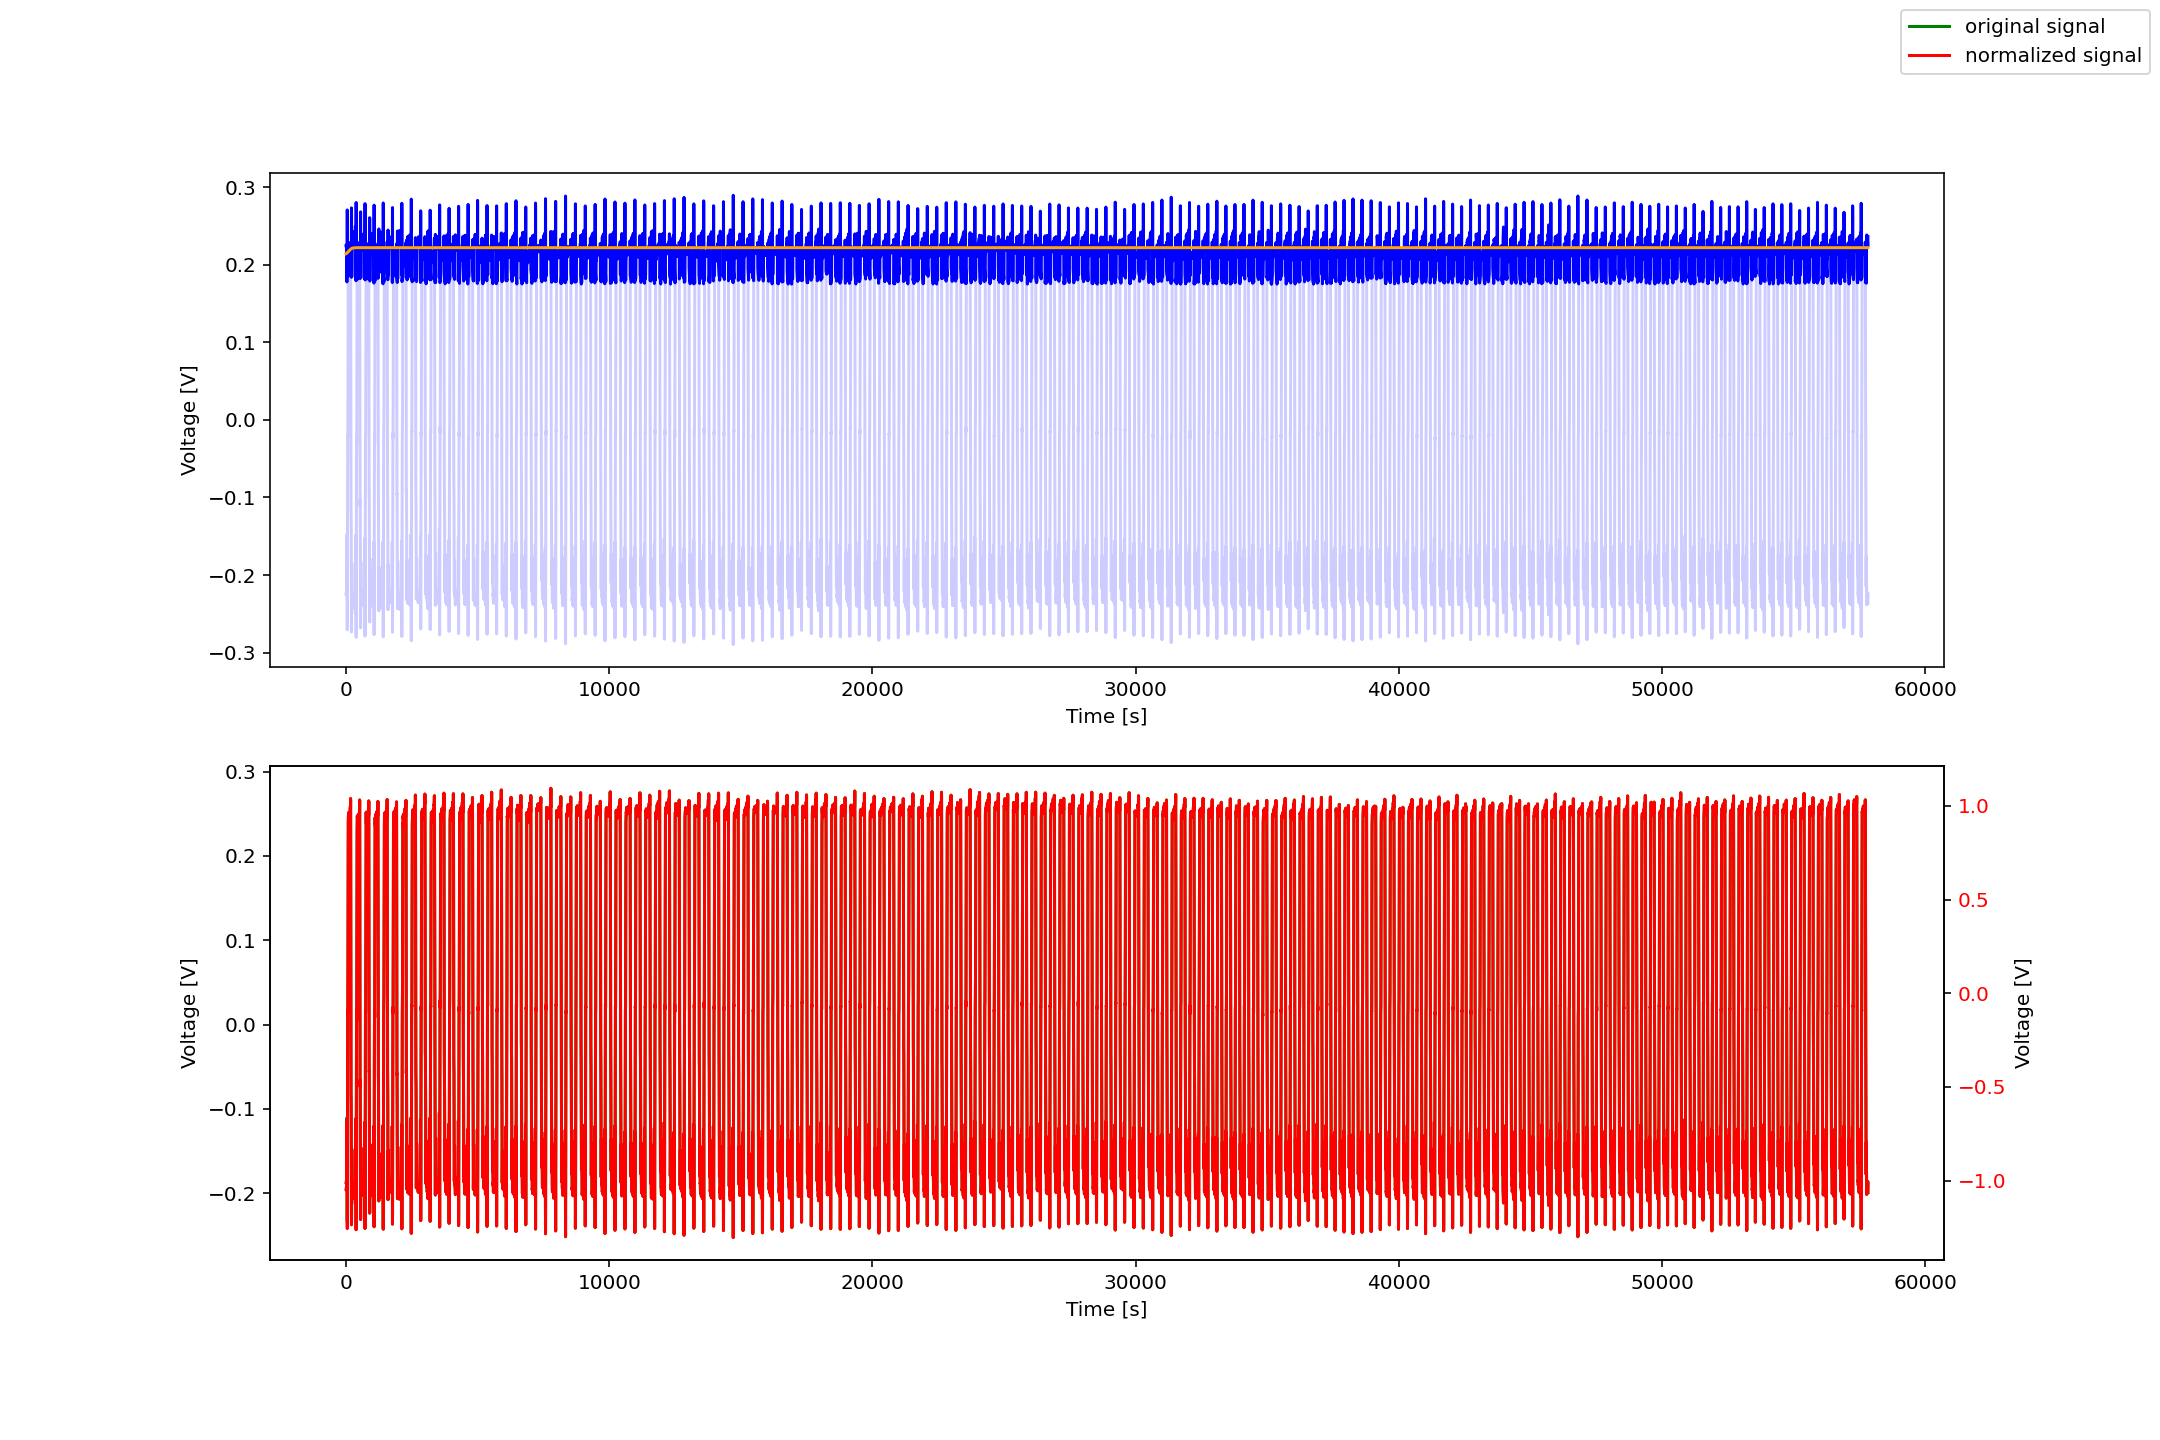

In [68]:
%matplotlib notebook
# %matplotlib notebook

xmin = 0
xmax = -1

# %matplotlib inline

# time = t[xmin:xmax]
# sig = sig1[xmin:xmax]

fig, r_sig2 = rectify(sig2_high[7240:], bell_func, plot_switch=True, p0=[70,0.02,1000,0.22],
                      bounds=([50,0,0,0], [100,1,100000,0.3]), ignore_bias=0.175)

# sig1 = n_sig

<IPython.core.display.Javascript object>


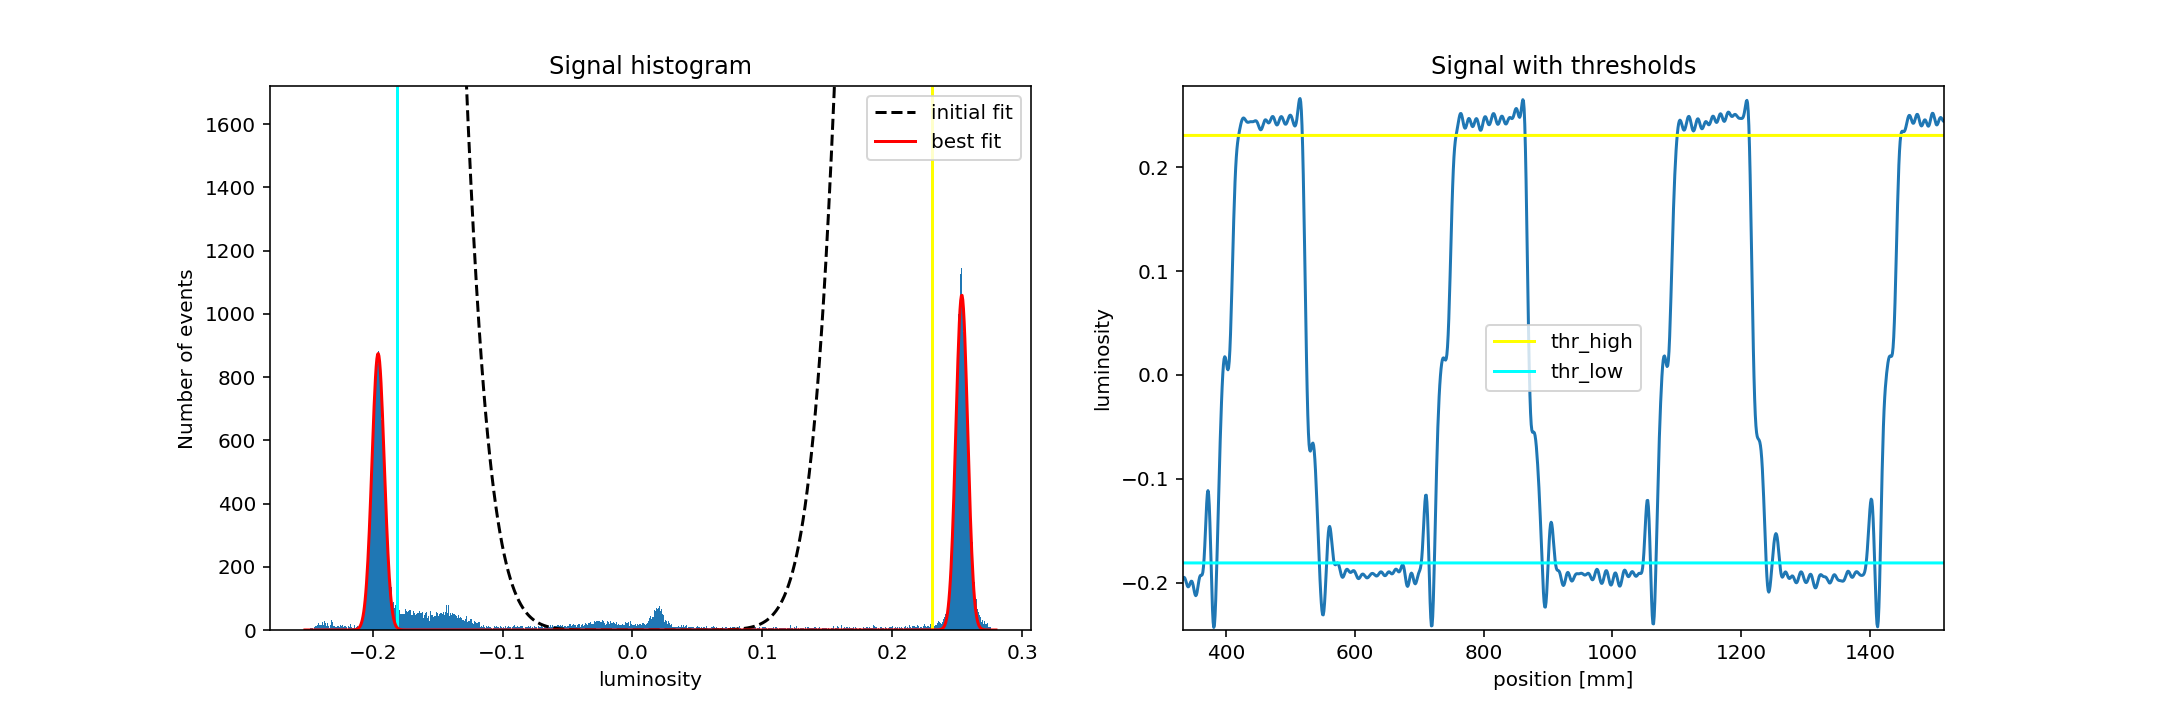

(-0.18099830994945781, 0.23070278107566677)

In [69]:
ddt.thr_searcher(sig2_high[7240:],nbins=1000)

<IPython.core.display.Javascript object>


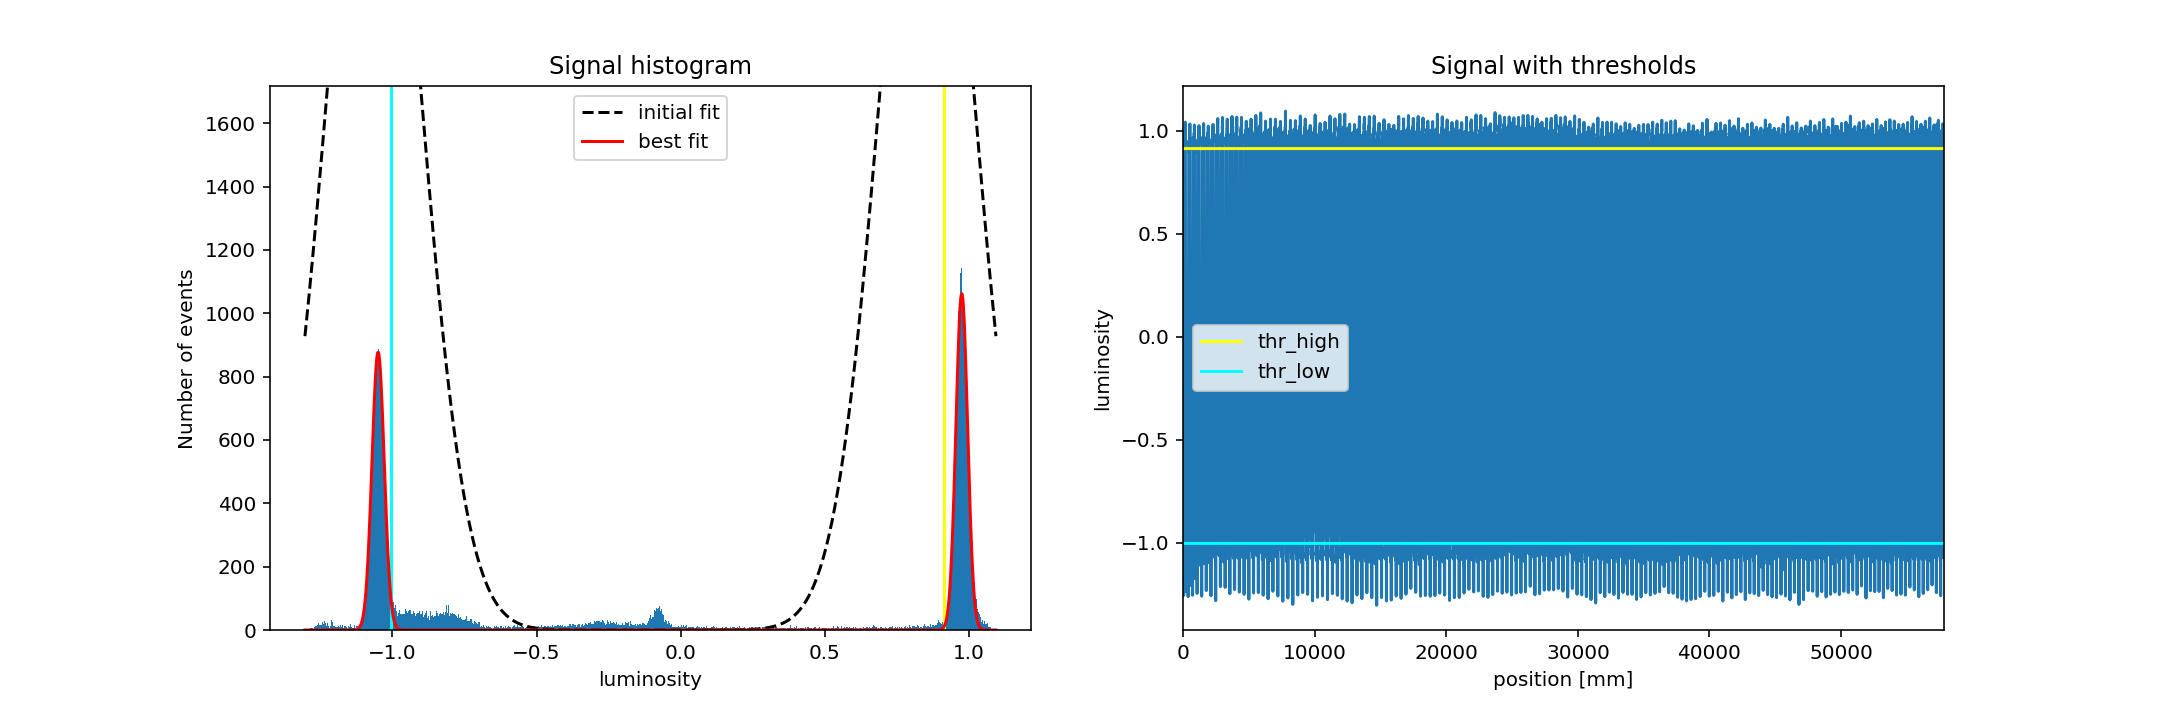

(-1.0039867772224775, 0.9124513526196742)

In [70]:
ddt.thr_searcher(r_sig2,nbins=1000, high_sigmas=3, low_sigmas=2)

## Fourier transformation


In [37]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 6000    # higher cut-off frequency
x_min     = 0       # signal plot x min.
x_max     = 20000   # signal plot x max.

### Signal 1 

<IPython.core.display.Javascript object>


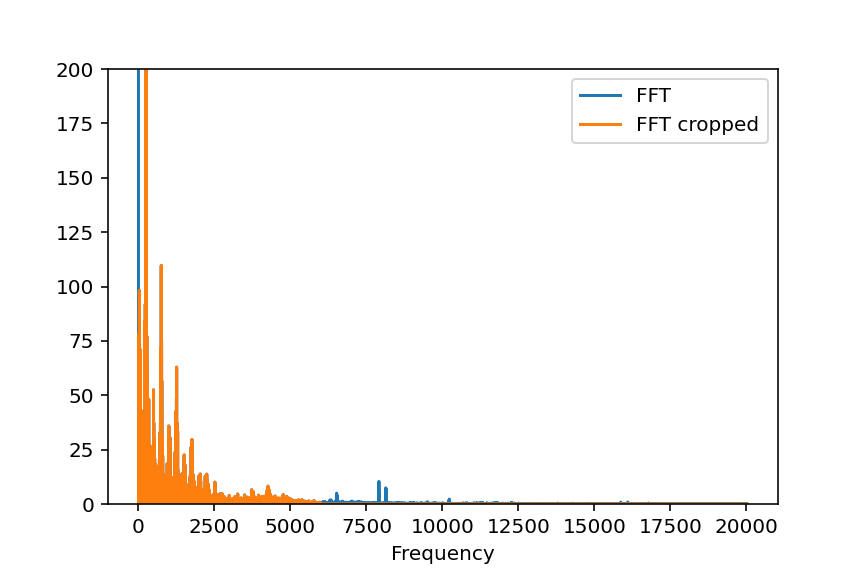

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


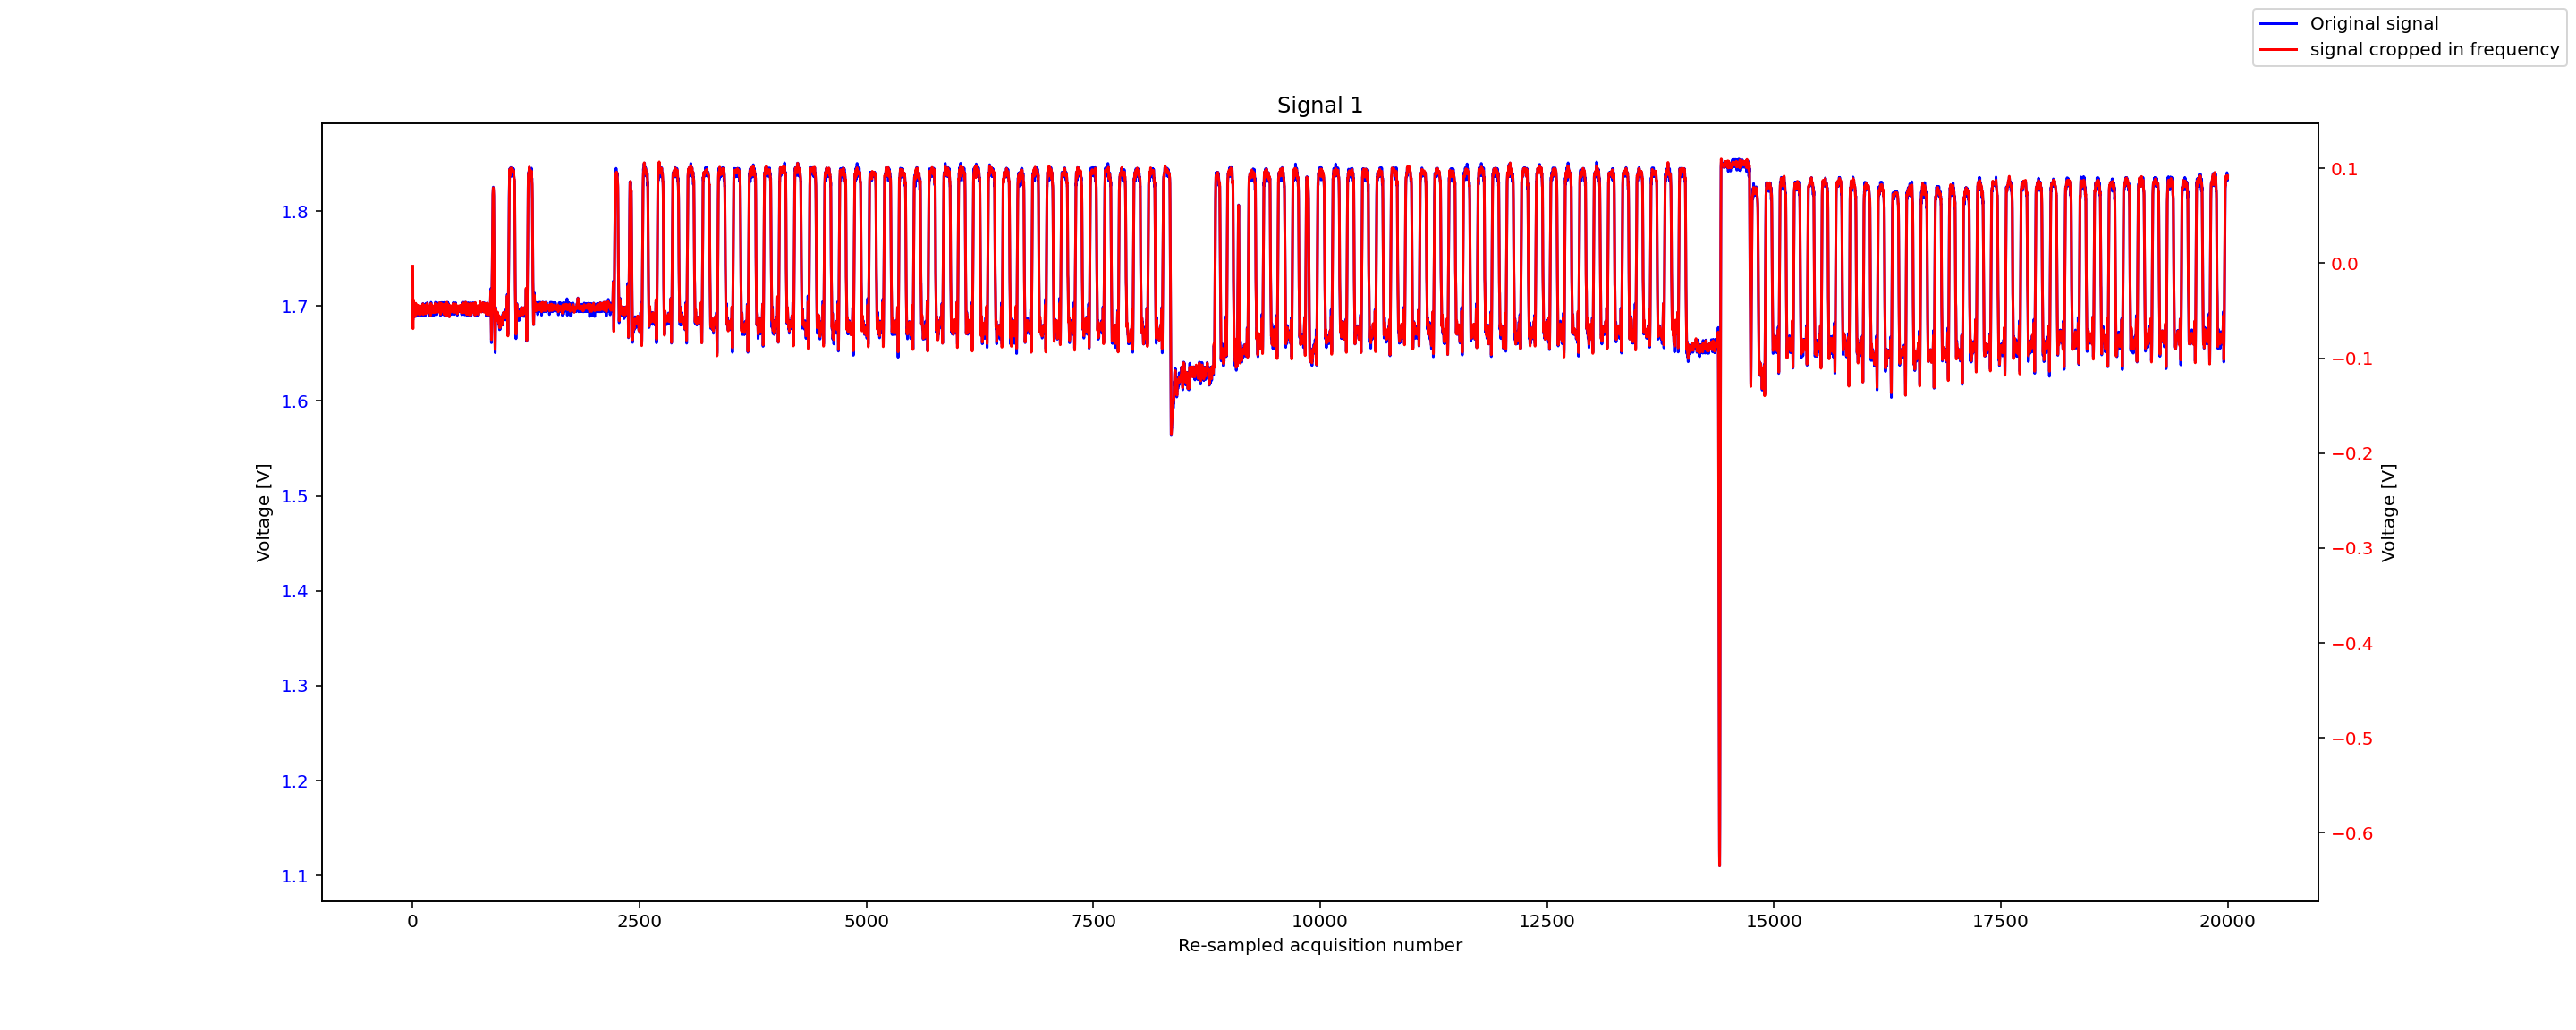

In [75]:
# FFT transform filtering
sig1_high = ddt.FFT_cropping(sig1, min_freq, max_freq)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'blue'
ax1.set_title('Signal 1')
ax1.set_xlabel('Re-sampled acquisition number')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig1[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor = color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()   
ax2.set_xlabel('Re-sampled acquisition number')
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig1_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()


### Signal 2 

<IPython.core.display.Javascript object>


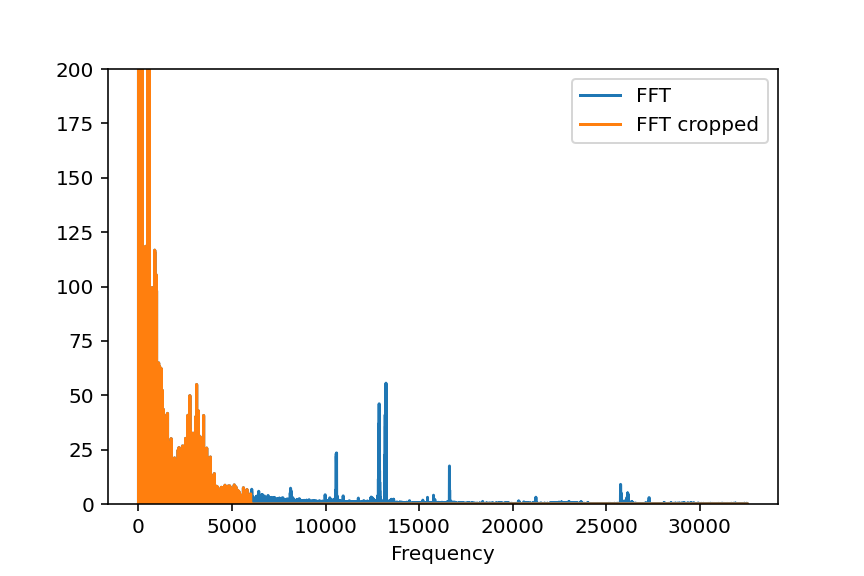

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


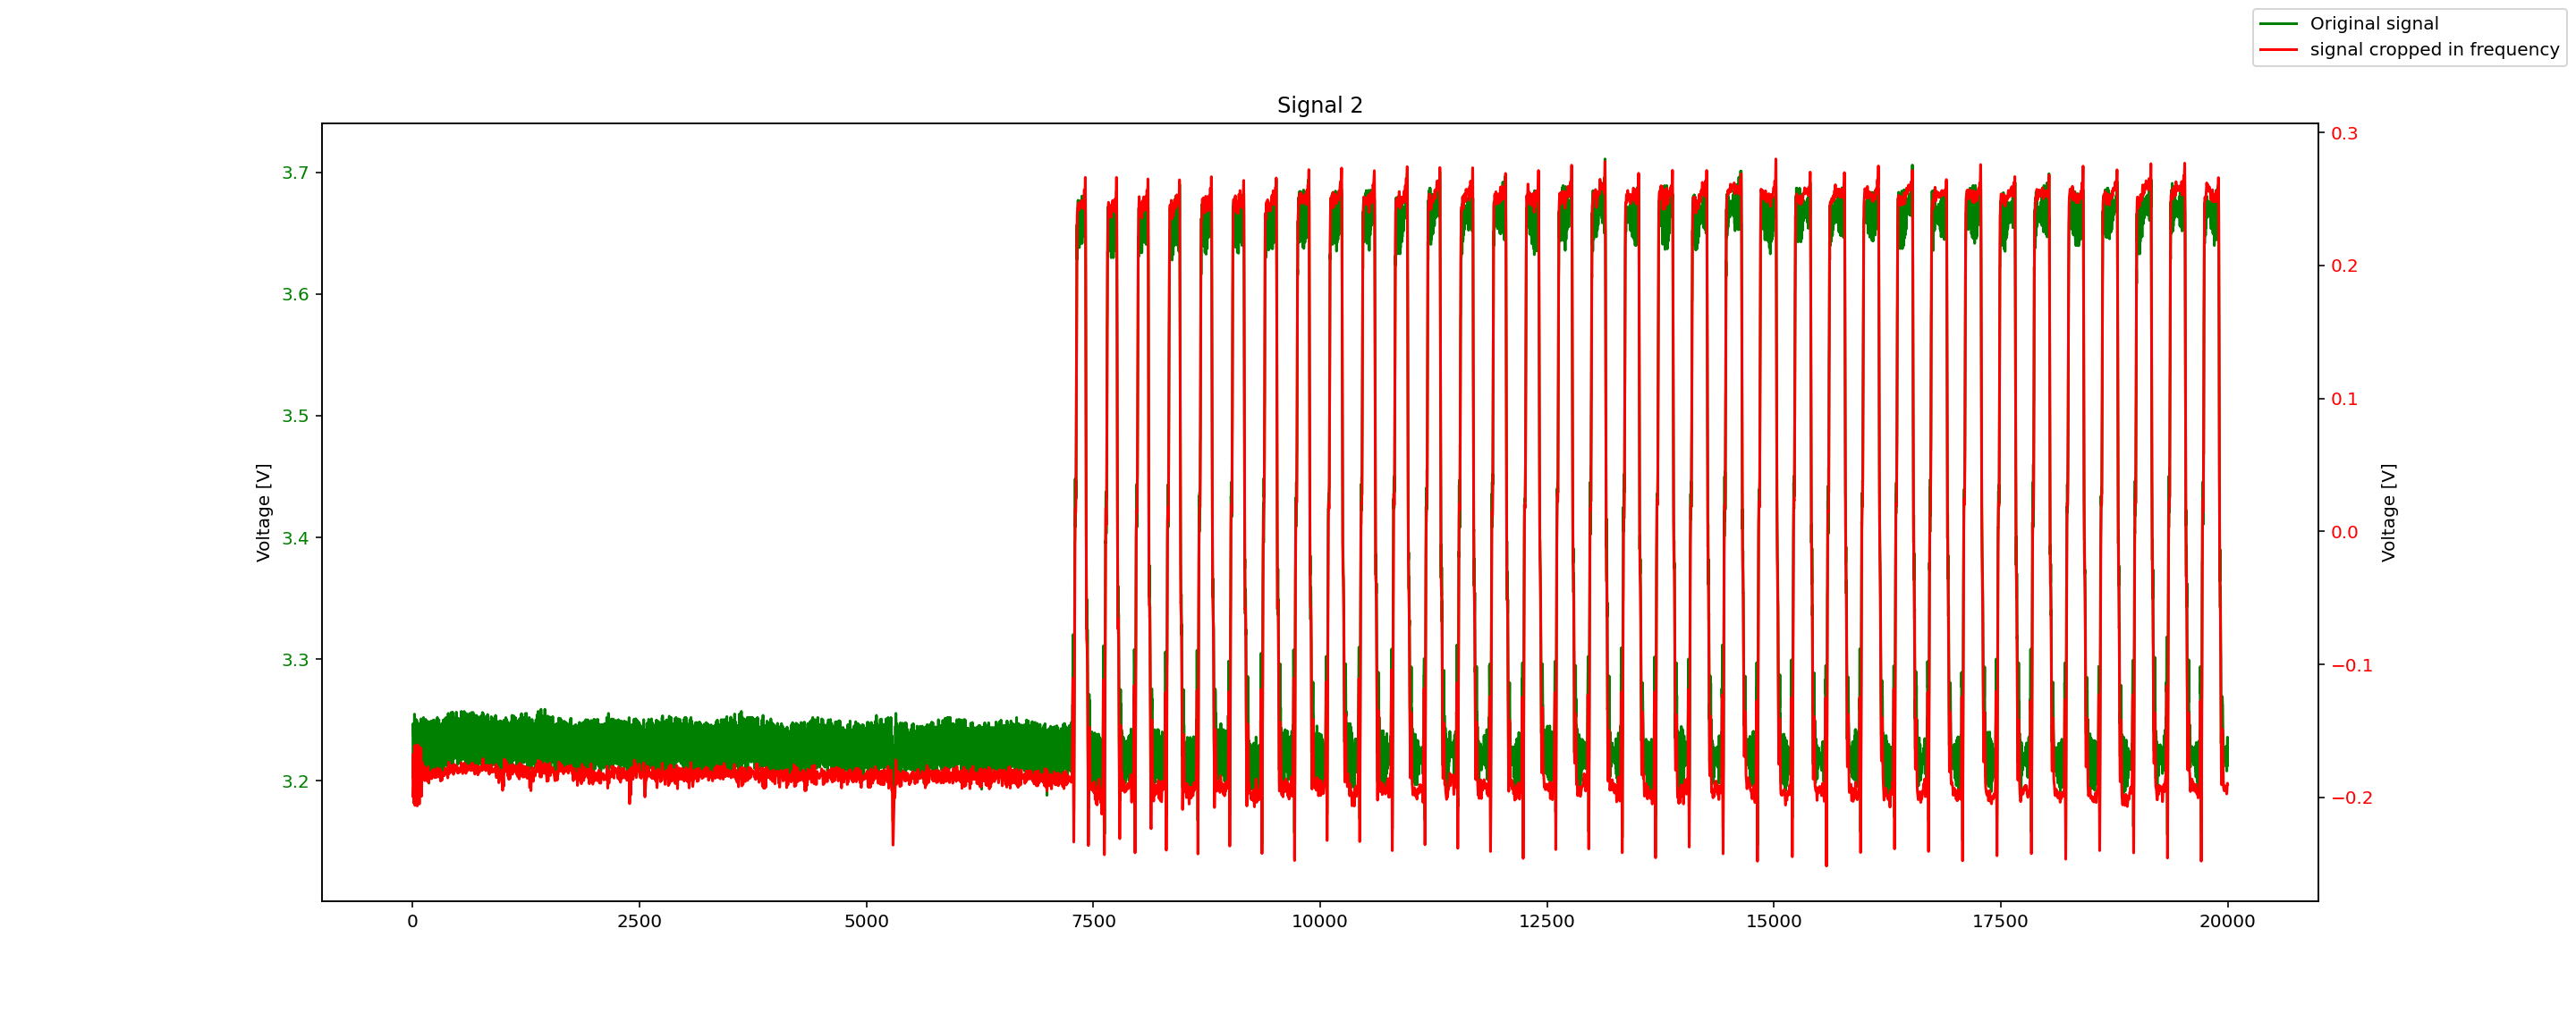

In [42]:
# FFT transform filtering
sig2_high = ddt.FFT_cropping(sig2, min_freq, max_freq)


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'green'
ax1.set_title('Signal 2')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig2[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor= color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()                                 
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig2_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()